<a href="https://colab.research.google.com/github/aworklab/aworklab.github.io/blob/master/ex_20221129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis 
* Iterators

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta 

import os
import re

from functools import reduce
from collections import defaultdict

import prophet as pr

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'mock_sales_data.csv',
 'mall_customers.csv',
 'groceries.csv',
 '1_customers_dataset.csv',
 'online_retail.xlsx',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'test.csv',
 '1_orders_dataset.csv',
 'match_result_test.csv',
 'sample-sales-data.csv',
 'sales_vs_discount.csv',
 'sales_data_with_stores.csv',
 'online_retail_II.xlsx',
 'sales.csv',
 '1_order_payments_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'ecommerce-data.csv',
 'bz_data_analyis.csv',
 'scanner_data.csv',
 'sample_data']

In [5]:
df = pd.read_csv('KPMG_VI_New_raw_data_update_final.csv')
df = df[df.order_status == 'Approved']
df.transaction_date = pd.to_datetime(df.transaction_date, infer_datetime_format=True)
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,date,month
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,2017-02-25,2017-02-01
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,2017-05-21,2017-05-01
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,2017-10-16,2017-10-01
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,2017-08-31,2017-08-01
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,2017-10-01,2017-10-01


In [11]:
cnt = df.groupby(['month', 'customer_id'])['list_price'].agg(['sum', 'count']).reset_index()
cnt.columns = ['month','id','rev', 'freq']
cnt.head()

,month,id,rev,freq
0,2017-01-01,1,360.40,1
1,2017-01-01,6,1769.64,1
2,2017-01-01,8,3454.46,2
3,2017-01-01,13,1890.39,1
4,2017-01-01,15,71.49,1


In [31]:
info_m = pd.pivot_table(cnt, index = 'id', columns = 'month', values = 'rev').reset_index()
info_m = pd.melt(info_m, id_vars = ['id'], var_name = 'month', value_name = 'money').sort_values(['id', 'month'], ascending = [1,0])
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()    

,id,money
0,1,9084.45
1,2,4149.07
2,3,9888.23
3,4,1047.72
4,5,5903.20


In [21]:
info_f = pd.pivot_table(cnt, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = ['id'], var_name = 'month', value_name = 'freq').sort_values(['id', 'month'], ascending = [1,0])
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()    

,id,freq
0,1,11.0
1,2,3.0
2,3,8.0
3,4,2.0
4,5,6.0


In [23]:
max_date = cnt['month'].max()
max_date

Timestamp('2017-12-01 00:00:00')

In [28]:
info_r = cnt.groupby(['id']).agg({'month' : lambda x : max_date - x.max()}).reset_index().rename(columns = {'month':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()

,id,recency
0,1,0
1,2,122
2,3,91
3,4,183
4,5,0


In [32]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info.head()

,id,recency,freq,money
0,1,0,11.0,9084.45
1,2,122,3.0,4149.07
2,3,91,8.0,9888.23
3,4,183,2.0,1047.72
4,5,0,6.0,5903.20


In [37]:
info = info.assign(r = pd.qcut(info['recency'].rank(method = 'first'), 5, list('12345')),
            f = pd.qcut(info['freq'].rank(method = 'first'), 5, list('54321')),
            m = pd.qcut(info['money'].rank(method = 'first'), 5, list('54321'))
            )
info['rm'] = info.r.astype(str) + info.m.astype(str)
info.head()

,id,recency,freq,money,r,f,m,rm
0,1,0,11.0,9084.45,1,1,1,11
1,2,122,3.0,4149.07,5,5,4,54
2,3,91,8.0,9888.23,4,2,1,41
3,4,183,2.0,1047.72,5,5,5,55
4,5,0,6.0,5903.20,1,3,3,13


In [40]:
cnt2 = info.groupby(['r','m'])['id'].count().reset_index()
cnt2.head()

,r,m,id
0,1,5,96
1,1,4,117
2,1,3,134
3,1,2,159
4,1,1,193


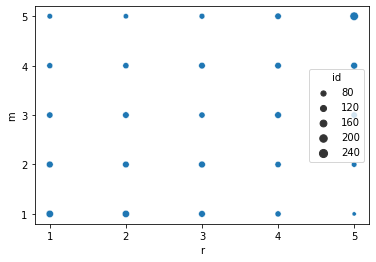

In [41]:
sns.scatterplot(data = cnt2, x = 'r', y = 'm', size = 'id')

# Iterators

In [42]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [44]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}